## Imports and experiment setup

In [1]:
%run header.py
%matplotlib inline

In [2]:
exp_path = "/nmnt/x04-hdd/boris_temp/SGIMC_IMC/article_instances/"

In [3]:
PROBLEM = "classification" if False else "regression"

step_fn = step_qaadmm

if PROBLEM == "classification":
    QAObjectiveLoss = QAObjectiveLogLoss
else:
    QAObjectiveLoss = QAObjectiveL2Loss  # QAObjectiveHuberLoss

In [4]:
if PROBLEM == "classification":
    C = 1e0, 1e-1, 1e-3
    eta = 1e0
else:
    # C = 2e-5, 2e-3, 0
    C = 2e-3, 2e-4, 1e-4
    eta = 1e1
    
step_kwargs = {
    "C": C,                 # the regularizr constants (C_lasso, C_group, C_ridge)
    "eta": eta,             # the eta of the ADMM (larger - faster but more unstable)
    "rtol": 1e-5,           # the relative tolerance for stopping the ADMM
    "atol": 1e-8,           # the absolute tolerance
    "method": "cg",         # the method to use in Sub_0
    "n_iterations": 2,      # the number of iterations of the inner ADMM
}

n_samples, n_objects = 800, 1600
n_rank = 25
n_features = 50

scale = 0.05
noise = 0.10

n_iter = 100

## Data creation

In [ ]:
for i, elem in enumerate(elements):
    X, W_ideal, Y, H_ideal, R_noisy_full, R_clean_full = make_imc_data(
        n_samples, n_features, n_objects, n_features,
        n_rank, scale=(scale, scale), noise=scale*noise,
        binarize=(PROBLEM == "classification"),
        random_state=random_state,
        return_noisy_only=False)

    _, mask = sparsify(R_noisy_full, elem, random_state=random_state)
    
    np.save(exp_path + "R_noisy_{}.npy".format(i), R_noisy_full)
    np.save(exp_path + "R_clean_{}.npy".format(i), R_clean_full)
    np.save(exp_path + "X_{}.npy".format(i), X)
    np.save(exp_path + "Y_{}.npy".format(i), Y)
    np.save(exp_path + "mask_{}.npy".format(i), mask)

## Parameter to vary

In [5]:
elements = np.arange(0.001, 0.05, 0.0005)
elem_short = elements[::3]

## Run experiment (K < n_rank)

In [6]:
K = 20

In [7]:
losses = []
for i, elem in enumerate(elements):
    R_noisy_full = np.load(exp_path + "R_noisy_{}.npy".format(i))
    R_clean_full = np.load(exp_path + "R_clean_{}.npy".format(i))
    X = np.load(exp_path + "X_{}.npy".format(i))
    Y = np.load(exp_path + "Y_{}.npy".format(i))
    mask = np.load(exp_path + "mask_{}.npy".format(i))

    R_train, mask = sparsify(R_noisy_full, elem, random_state=random_state)
    problem = IMCProblem(QAObjectiveLoss, X, Y, R_train, n_threads=8)

    W_0 = random_state.normal(size=(X.shape[1], K))
    H_0 = random_state.normal(size=(Y.shape[1], K))

    W, H = W_0.copy(), H_0.copy()

    W, H = imc_descent(problem, W, H,
                       step_fn,                  # the inner optimization
                       step_kwargs=step_kwargs,  # asrtguments for the inner optimizer
                       n_iterations=n_iter,      # the number of outer iterations (Gauss-Siedel)
                       n_init_iterations=0,
                       return_history=True,      # Record the evolution of the matrices (W, H)
                       rtol=1e-5,                # relative stopping tolerance for the outer iterations
                       atol=1e-7,                # absolute tolerance
                       verbose=False,            # show the progress bar
                       check_product=True,       # use the product W H' for stopping
                      )

    losses.append(calculate_loss(R_clean_full, X, W, H, Y, invert(mask)))
    
losses = np.array(losses)
np.save(exp_path + "results_sgimc.npy", losses)

## Run experiment (K > n_rank)

In [7]:
K = 30

In [9]:
losses = []
for i, elem in enumerate(elements):
    R_noisy_full = np.load(exp_path + "R_noisy_{}.npy".format(i))
    R_clean_full = np.load(exp_path + "R_clean_{}.npy".format(i))
    X = np.load(exp_path + "X_{}.npy".format(i))
    Y = np.load(exp_path + "Y_{}.npy".format(i))
    mask = np.load(exp_path + "mask_{}.npy".format(i))

    R_train = sparsify_with_mask(R_noisy_full, mask)
    problem = IMCProblem(QAObjectiveLoss, X, Y, R_train, n_threads=8)

    W_0 = random_state.normal(size=(X.shape[1], K))
    H_0 = random_state.normal(size=(Y.shape[1], K))

    W, H = W_0.copy(), H_0.copy()

    W, H = imc_descent(problem, W, H,
                       step_fn,                  # the inner optimization
                       step_kwargs=step_kwargs,  # asrtguments for the inner optimizer
                       n_iterations=n_iter,      # the number of outer iterations (Gauss-Siedel)
                       n_init_iterations=0,
                       return_history=True,      # Record the evolution of the matrices (W, H)
                       rtol=1e-5,                # relative stopping tolerance for the outer iterations
                       atol=1e-7,                # absolute tolerance
                       verbose=False,            # show the progress bar
                       check_product=True,       # use the product W H' for stopping
                      )

    losses.append(calculate_loss(R_clean_full, X, W, H, Y, invert(mask)))
    
losses = np.array(losses)
np.save(exp_path + "results_sgimc_1.npy", losses)

## Plots

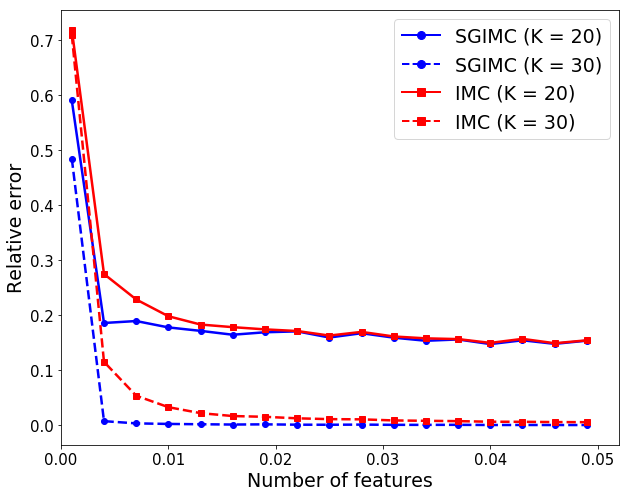

In [6]:
exp_path = "/nmnt/x04-hdd/boris_temp/SGIMC_IMC/article_instances/"

sgimc_losses = np.load(exp_path + "results_sgimc.npy")
imc_losses = np.load(exp_path + "results_imc.npy")

sgimc_losses_1 = np.load(exp_path + "results_sgimc_1.npy")
imc_losses_1 = np.load(exp_path + "results_imc_1.npy")


################################### FIGURE ###################################
plt.figure(figsize=(10,8))

# lines
sgimc_line = mlines.Line2D([], [], color='blue', marker='o', linewidth=2,
                           markersize=8, label='SGIMC (K = 20)')
sgimc_line_1 = mlines.Line2D([], [], color='blue', marker='o', linewidth=2, linestyle='--',
                             markersize=8, label='SGIMC (K = 30)')
imc_line = mlines.Line2D([], [], color='red', marker='s', linewidth=2,
                         markersize=8, label='IMC (K = 20)')
imc_line_1 = mlines.Line2D([], [], color='red', marker='s', linewidth=2, linestyle='--',
                           markersize=8, label='IMC (K = 30)')


skip = 3
_skip = 2

# curves
plt.plot(elements[::skip][::_skip], sgimc_losses[::skip][::_skip], 'b-', label='SGIMC (K = 20)', linewidth=2.5)
plt.plot(elements[::skip][::_skip], sgimc_losses_1[::skip][::_skip], 'b--', label='SGIMC (K = 30)', linewidth=2.5)
plt.plot(elements[::skip][::_skip], imc_losses[::_skip], 'r-', label='IMC (K = 20)', linewidth=2.5)
plt.plot(elements[::skip][::_skip], imc_losses_1[::_skip], 'r--', label='IMC (K = 30)', linewidth=2.5)

# dotes
plt.plot(elements[::skip][::_skip], sgimc_losses[::skip][::_skip], 'bo', label='SGIMC (K = 20)', linewidth=2.5)
plt.plot(elements[::skip][::_skip], sgimc_losses_1[::skip][::_skip], 'bo', label='SGIMC (K = 30)', linewidth=2.5)
plt.plot(elements[::skip][::_skip], imc_losses[::_skip], 'rs', label='IMC (K = 20)', linewidth=2.5)
plt.plot(elements[::skip][::_skip], imc_losses_1[::_skip], 'rs', label='IMC (K = 30)', linewidth=2.5)

# specify axis limits and labels
plt.xlim((0,0.052))
plt.xlabel('Number of features', fontsize=19)
plt.ylabel('Relative error', fontsize=19)

# ticks
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

# legend
plt.legend(handles=[sgimc_line, sgimc_line_1, imc_line, imc_line_1], fontsize=19, loc=1)

plt.show()
# TODO: save as pdf
# TODO: dpi 200